## Basic GAN Implementation

We will attempt to generate samples from MNIST dataset using GAN.

This is an attempt to implement the original paper on GAN (https://arxiv.org/pdf/1406.2661.pdf)

In [80]:
#Import block

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

from random import shuffle

import gc

In [57]:
train_on_gpu = True

#Hyper parameters of the model
batch_size = 64
gen_lr = 0.1
dis_lr = 0.1

noise_ratio = 0.2
smooth_param = 0.9

epoch = 30

In [58]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

mnist_train = datasets.MNIST(root='data', download=True, train=True, transform= transform)
mnist_test = datasets.MNIST(root = 'data', download = True, train=False, transform=transform)

In [59]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [60]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [61]:
trainloader = DataLoader(mnist_train, shuffle=True, batch_size= batch_size)
testloader = DataLoader(mnist_test, shuffle=True, batch_size= batch_size)

7

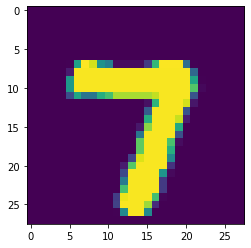

In [62]:
#Visualize each of the image and its label
images, labels = next(iter(trainloader))
img = images[0].view(28,28)
lab = labels[0]

img = (img+1)/2

plt.imshow(img)
lab.item()

Now we have imported the data, created Training and Test Set

We will now create our Neural Network model along with Optimizers and loss function

## Generator Architecture
1 input layer 

3 hidden layers with relu activation

1 output layer with tanh activation

We will input a latent vector of size 100

First layer will have input and output as (100, 4*16 =64)

Second layer : (64, 4*32 = 128)

Third layer : (128, 4*64 = 256)

Fourth Layer : (256, 512)

Output layer : (512, output = 784)
## Discriminator Architecture
1 input layer

3 hidden layers with relu activation

1 output layer with sigmoid activation

We will input an image of size 28*28 (784 unrolled)

Input layer : (784, 512)

FIrst Layer : (512,256)

Second layer : (256, 128)

Third Layer : (128, 32)

Output layer : (32, 1)

In [63]:
class Generator(nn.Module):
    
    def __init__(self, input_size, hidden_size = 4, output_size = 784):
        super().__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_size*16)
        self.layer2 = nn.Linear(hidden_size*16, hidden_size*32)
        self.layer3 = nn.Linear(hidden_size*32, hidden_size*64)
        self.layer4 = nn.Linear(hidden_size*64, hidden_size*128)
        
        self.output = nn.Linear(hidden_size*128, output_size)
        
        self.dropout = nn.Dropout(p=0.2)
    
    #Input would be a batch_size*28*28 tensor
    def forward(self, x):
        
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.dropout(x)
        x = F.relu(self.layer4(x))
        
        x = F.tanh(self.output(x))
        
        return x

In [64]:
class Discriminator(nn.Module):
    
    def __init__(self, input_size, hidden_size = 4, output_size = 1):
        super().__init__()
        
        self.layer1 = nn.Linear(input_size, hidden_size*128)
        self.layer2 = nn.Linear(hidden_size*128, hidden_size*64)
        self.layer3 = nn.Linear(hidden_size*64, hidden_size*32)
        self.layer4 = nn.Linear(hidden_size*32, hidden_size*8)
        
        self.output = nn.Linear(hidden_size*8,output_size)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        
        x = x.view(-1, 784)
        
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.dropout(x)
        x = F.relu(self.layer4(x))
        
        return F.sigmoid(self.output(x))

In [83]:
#Training function
def train(epochs = 10, smooth = False, add_noise = False, show_test_image = False):
    
    latent_test = (torch.rand(1,100) - 0.5)/0.5
    
    discriminator = Discriminator(784)
    generator = Generator(100,4,784)

    if train_on_gpu == True:
        discriminator.cuda()
        generator.cuda()
        latent_test = latent_test.cuda()
    
    gen_optim = optim.SGD(generator.parameters(), lr = gen_lr)
    dis_optim = optim.SGD(discriminator.parameters(), lr = dis_lr)
    
    loss_fn_gen = nn.BCELoss()
    loss_fn_dis = nn.BCELoss()
        
    gen_loss = []
    dis_loss_real = []
    dis_loss_fake = []
    
    for i in range(epochs):
        running_loss_disc_real = 0
        running_loss_disc_fake = 0
        running_loss_gen = 0
        
        generator.train()
        discriminator.train()
        
        for real_images, labels in trainloader:
            
            label_zero = torch.zeros(len(labels))
            label_one = torch.ones(len(labels))
            label_one_gen = torch.ones(len(labels))
            
            if(add_noise == True):
                index = list(range(len(labels)))
                shuffle(index)
                noise_len = int(noise_ratio*len(labels))
                for ind in index[:noise_len]:
                    label_zero[ind] = 1
                    label_one[ind] = 0
            
            if train_on_gpu == True:
                real_images = real_images.cuda()
                label_zero = label_zero.cuda()
                label_one = label_one.cuda()
                label_one_gen = label_one_gen.cuda()
            
            dis_optim.zero_grad()
            
            #Generate fake samples equal to that of batchsize
            #Normalize it to range of [-1,1] similar to real input images
            latent = torch.rand(len(labels), 100)
            latent = (latent-0.5)/0.5
    
            if train_on_gpu == True:
                latent = latent.cuda()
    
            fake = generator(latent)
            
            #Find loss for discriminator
            loss_disc_real = None
            if smooth == True:
                loss_disc_real = loss_fn_dis(discriminator(real_images),label_one*0.9)
            else:
                loss_disc_real = loss_fn_dis(discriminator(real_images),label_one)
            loss_disc_fake = loss_fn_dis(discriminator(fake),label_zero)
            loss_disc =  loss_disc_real + loss_disc_fake
            loss_disc.backward(retain_graph = True)
            
            dis_optim.step()
            
            gen_optim.zero_grad()
            
            #Find loss for generator
            loss_gen = loss_fn_gen(discriminator(fake),label_one_gen)
            loss_gen.backward()
            
            gen_optim.step()
            
            running_loss_disc_real += loss_disc_real.item()
            running_loss_disc_fake += loss_disc_fake.item()
            running_loss_gen += loss_gen.item()
        
        print('Generator Loss after {} epoch is {} and Discriminator loss is {} on real images and {} on fake images'.format(i+1,running_loss_gen,running_loss_disc_real, running_loss_disc_fake))
        if show_test_image == True:
            generator.eval()
            gen_img_test = generator(latent_test)
            gen_img_test = ((gen_img_test.view(28,28)+1)/2).detach().cpu().data.numpy()
            plt.imshow(gen_img_test)
            show()
        
        gen_loss.append(running_loss_gen)
        dis_loss_real.append(running_loss_disc_real)
        dis_loss_fake.append(running_loss_disc_fake)
    
    plt.plot(gen_loss,label = 'Generator Loss')
    plt.plot(dis_loss_real, label = 'Discriminator Loss Real')
    plt.plot(dis_loss_fake, label = 'Discriminator Loss Fake')
    plt.legend()
    plt.show()
    
    return generator, discriminator

Generator Loss after 1 epoch is 2536.4597502313554 and Discriminator loss is 97.96077202660672 on real images and 188.35725574940443 on fake images
Generator Loss after 2 epoch is 2823.703704930842 and Discriminator loss is 286.895600062795 on real images and 214.9733715262264 on fake images
Generator Loss after 3 epoch is 2918.8230471611023 and Discriminator loss is 253.6609225955326 on real images and 166.12215474806726 on fake images
Generator Loss after 4 epoch is 4409.282904744148 and Discriminator loss is 15.594518785699952 on real images and 20.246905781095847 on fake images
Generator Loss after 5 epoch is 6095.264954566956 and Discriminator loss is 0.2678710042627246 on real images and 2.304011850093957 on fake images
Generator Loss after 6 epoch is 3766.3293763548136 and Discriminator loss is 266.60760619633123 on real images and 174.245099957727 on fake images
Generator Loss after 7 epoch is 3137.458172917366 and Discriminator loss is 188.58928991205903 on real images and 106

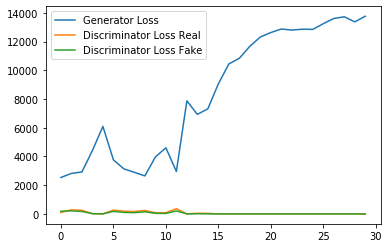

In [16]:
gen_lr = 0.02
dis_lr = 0.02
generator, discriminator = (None, None)
gc.collect()
generator, discriminator = train(epoch)

Generator Loss after 1 epoch is 1210.8554687611759 and Discriminator loss is 524.4627885362752 on real images and 488.2327640866861 on fake images
Generator Loss after 2 epoch is 921.1878272891045 and Discriminator loss is 588.3991173431277 on real images and 560.7361562848091 on fake images
Generator Loss after 3 epoch is 910.4889005720615 and Discriminator loss is 590.9471036531031 on real images and 547.4070973545313 on fake images
Generator Loss after 4 epoch is 788.3005692064762 and Discriminator loss is 607.653265081346 on real images and 589.9102375805378 on fake images
Generator Loss after 5 epoch is 1010.0308953225613 and Discriminator loss is 548.6771929264069 on real images and 508.8961073309183 on fake images
Generator Loss after 6 epoch is 1186.58996707201 and Discriminator loss is 511.04178934078664 on real images and 444.8436367549002 on fake images
Generator Loss after 7 epoch is 1290.232186973095 and Discriminator loss is 515.5886303894222 on real images and 444.596925

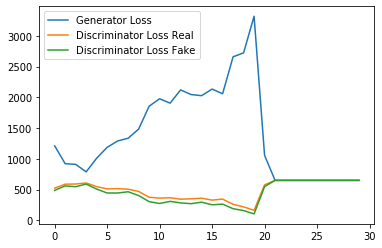

In [18]:
gen_lr = 0.1
dis_lr = 0.1
generator, discriminator = (None, None)
gc.collect()
generator, discriminator = train(epoch)

Generator Loss after 1 epoch is 946.1544971913099 and Discriminator loss is 579.0709121313415 on real images and 552.990371171385 on fake images
Generator Loss after 2 epoch is 875.6945966780186 and Discriminator loss is 597.8120858110487 on real images and 582.8455219566822 on fake images
Generator Loss after 3 epoch is 1387.8384585380554 and Discriminator loss is 492.9253294561058 on real images and 453.2549247443676 on fake images
Generator Loss after 4 epoch is 1513.735812485218 and Discriminator loss is 465.4535719230771 on real images and 404.4949334152043 on fake images
Generator Loss after 5 epoch is 2230.745372454636 and Discriminator loss is 340.59394092223374 on real images and 264.9353074019018 on fake images
Generator Loss after 6 epoch is 7200.166091919593 and Discriminator loss is 34.9141394769364 on real images and 28.55754862302274 on fake images
Generator Loss after 7 epoch is 11088.167342185974 and Discriminator loss is 0.05185066974143737 on real images and 0.151378

Generator Loss after 54 epoch is 19574.598766326904 and Discriminator loss is 0.000523150872097089 on real images and 0.002354606357228173 on fake images
Generator Loss after 55 epoch is 19659.430418014526 and Discriminator loss is 0.0004041323583867662 on real images and 0.0025646127345533287 on fake images
Generator Loss after 56 epoch is 19712.064414978027 and Discriminator loss is 0.0003828026700853915 on real images and 0.0019612279365057717 on fake images
Generator Loss after 57 epoch is 19703.31964492798 and Discriminator loss is 0.0003387301318078517 on real images and 0.002391613764980427 on fake images
Generator Loss after 58 epoch is 19826.116010665894 and Discriminator loss is 0.0003941442875914358 on real images and 0.0020911251515149942 on fake images
Generator Loss after 59 epoch is 19906.829877853394 and Discriminator loss is 0.0002987688152189527 on real images and 0.0020654695305353243 on fake images
Generator Loss after 60 epoch is 19991.428812026978 and Discriminato

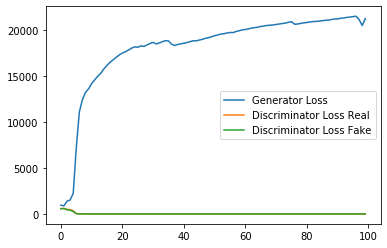

In [22]:
gen_lr = 0.1
dis_lr = 0.1
generator, discriminator = (None, None)
gc.collect()
generator, discriminator = train(100)

Generator Loss after 1 epoch is 1180.2474068775773 and Discriminator loss is 540.4105762775653 on real images and 507.5912408577278 on fake images
Generator Loss after 2 epoch is 741.5838561505079 and Discriminator loss is 633.4733397327363 on real images and 624.8195824511349 on fake images
Generator Loss after 3 epoch is 871.8386676609516 and Discriminator loss is 605.0017636753619 on real images and 577.9281427264214 on fake images
Generator Loss after 4 epoch is 1026.573736499995 and Discriminator loss is 555.043917030096 on real images and 530.2220127619803 on fake images
Generator Loss after 5 epoch is 1196.4464832544327 and Discriminator loss is 515.3949996940792 on real images and 450.49765622615814 on fake images
Generator Loss after 6 epoch is 1375.0971550047398 and Discriminator loss is 497.10590313584544 on real images and 423.2317444887012 on fake images
Generator Loss after 7 epoch is 1727.9754279404879 and Discriminator loss is 400.9385321630398 on real images and 337.14

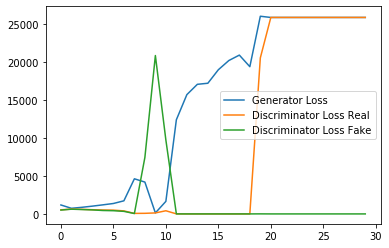

In [33]:
gen_lr = 0.1
dis_lr = 0.1
generator, discriminator = (None, None)
gc.collect()
generator, discriminator = train(30)

## Techniques to ensure that the learning is stable
https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

Our main task is to ensure that discriminator is weak as compared to generator

1. Adding Noise to our dataset

2. Applying label smoothing

3. Using different learning rates for discriminator and generator

Generator Loss after 1 epoch is 1049.5958378314972 and Discriminator loss is 549.7475918233395 on real images and 519.1642813682556 on fake images
Generator Loss after 2 epoch is 1150.9445487260818 and Discriminator loss is 533.4258613586426 on real images and 495.57511883974075 on fake images
Generator Loss after 3 epoch is 1164.1822256445885 and Discriminator loss is 518.5221428871155 on real images and 494.46198016405106 on fake images
Generator Loss after 4 epoch is 1135.7253996133804 and Discriminator loss is 528.1639000475407 on real images and 498.85050669312477 on fake images
Generator Loss after 5 epoch is 1191.3148867487907 and Discriminator loss is 512.582570374012 on real images and 486.47004014253616 on fake images
Generator Loss after 6 epoch is 1064.9896373152733 and Discriminator loss is 543.3367270231247 on real images and 506.77431854605675 on fake images
Generator Loss after 7 epoch is 1210.4730322360992 and Discriminator loss is 505.1926926970482 on real images and 

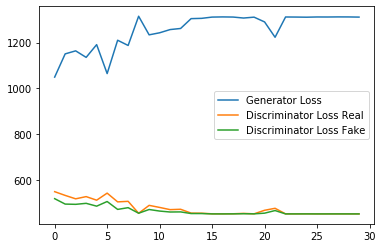

In [74]:
gen_lr = 0.1
dis_lr = 0.1
generator, discriminator = (None, None)
gc.collect()
generator, discriminator = train(30, smooth=False, add_noise= True)

C:\Users\harsh\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\harsh\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\harsh\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\harsh\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same si

Generator Loss after 1 epoch is 1629.7376356869936 and Discriminator loss is 392.57543924450874 on real images and 390.13677978515625 on fake images


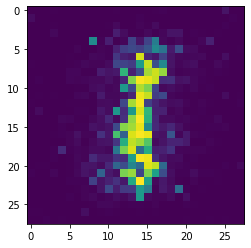

Generator Loss after 2 epoch is 1811.092589020729 and Discriminator loss is 432.47625482082367 on real images and 356.0864991545677 on fake images


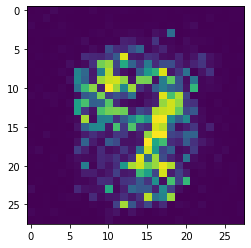

Generator Loss after 3 epoch is 2032.6280020475388 and Discriminator loss is 384.67941984534264 on real images and 332.81392121315 on fake images


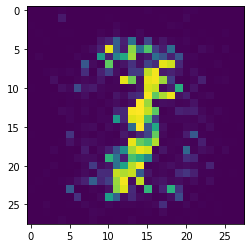

Generator Loss after 4 epoch is 1863.7294545173645 and Discriminator loss is 399.08685952425003 on real images and 332.61646834015846 on fake images


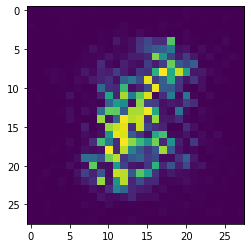

Generator Loss after 5 epoch is 1791.8005357086658 and Discriminator loss is 418.49217906594276 on real images and 358.83923348784447 on fake images


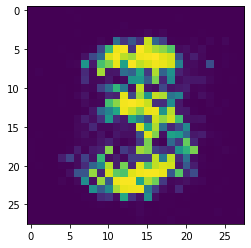

Generator Loss after 6 epoch is 2037.2356238365173 and Discriminator loss is 346.6450768709183 on real images and 321.81836473941803 on fake images


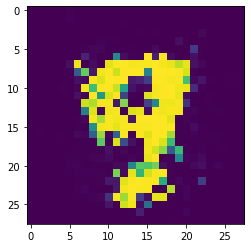

Generator Loss after 7 epoch is 2084.3589866161346 and Discriminator loss is 343.6884537935257 on real images and 321.05569237470627 on fake images


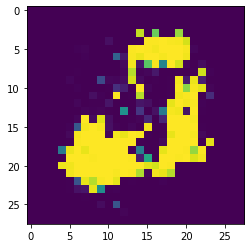

Generator Loss after 8 epoch is 2165.801679253578 and Discriminator loss is 336.00806534290314 on real images and 309.9632377922535 on fake images


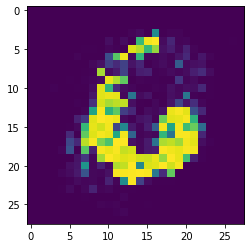

Generator Loss after 9 epoch is 2127.5972853899 and Discriminator loss is 340.0038080662489 on real images and 309.82802975177765 on fake images


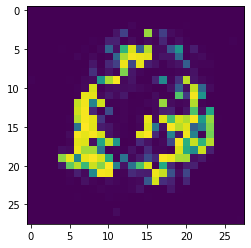

Generator Loss after 10 epoch is 2101.588651776314 and Discriminator loss is 334.9362779855728 on real images and 305.1790364086628 on fake images


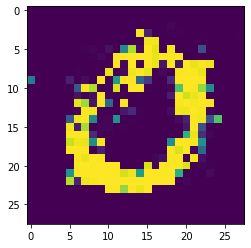

Generator Loss after 11 epoch is 2072.2479219436646 and Discriminator loss is 336.0057207643986 on real images and 303.9944277703762 on fake images


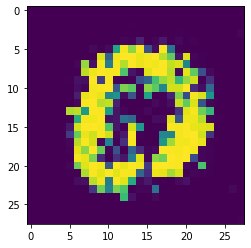

Generator Loss after 12 epoch is 2037.0821194648743 and Discriminator loss is 361.97274655103683 on real images and 322.268136292696 on fake images


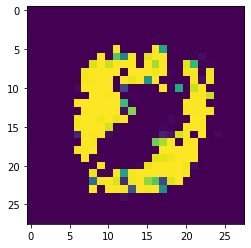

Generator Loss after 13 epoch is 2110.64332818985 and Discriminator loss is 338.5734863728285 on real images and 307.4361843466759 on fake images


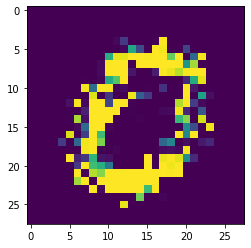

Generator Loss after 14 epoch is 2139.2182570695877 and Discriminator loss is 322.4747411161661 on real images and 302.7996824979782 on fake images


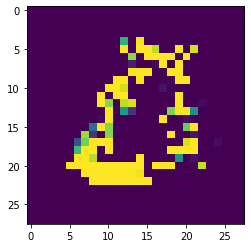

Generator Loss after 15 epoch is 2147.49022769928 and Discriminator loss is 324.30646377801895 on real images and 306.0047229528427 on fake images


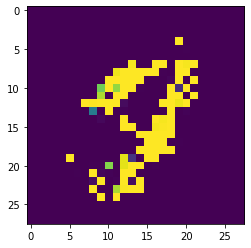

Generator Loss after 16 epoch is 2147.165425300598 and Discriminator loss is 317.6605026423931 on real images and 301.62602043151855 on fake images


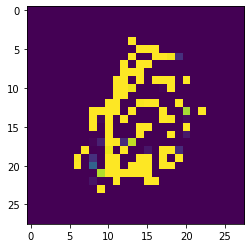

Generator Loss after 17 epoch is 2065.969255566597 and Discriminator loss is 340.21672278642654 on real images and 311.494573533535 on fake images


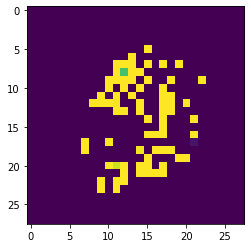

Generator Loss after 18 epoch is 1915.5131059885025 and Discriminator loss is 377.23817509412766 on real images and 328.7571604549885 on fake images


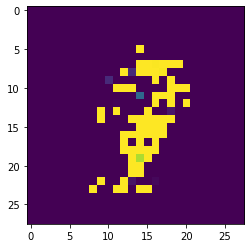

Generator Loss after 19 epoch is 2176.648462533951 and Discriminator loss is 307.4939026236534 on real images and 296.1000055670738 on fake images


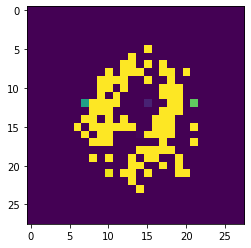

Generator Loss after 20 epoch is 2211.2038263082504 and Discriminator loss is 294.9594834446907 on real images and 292.8701533973217 on fake images


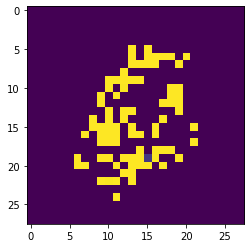

Generator Loss after 21 epoch is 2206.0788987874985 and Discriminator loss is 296.5141428411007 on real images and 293.01143327355385 on fake images


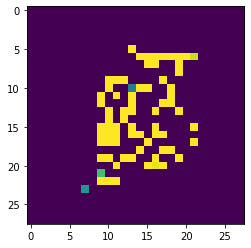

Generator Loss after 22 epoch is 2145.028094112873 and Discriminator loss is 313.26365143060684 on real images and 304.3861560225487 on fake images


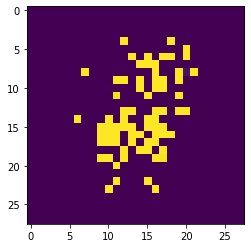

Generator Loss after 23 epoch is 2214.0072956085205 and Discriminator loss is 292.83206418156624 on real images and 292.6178871393204 on fake images


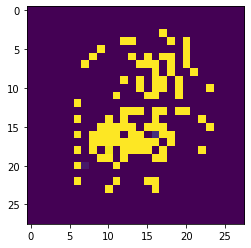

Generator Loss after 24 epoch is 2219.8898305892944 and Discriminator loss is 292.5304720699787 on real images and 292.0710614621639 on fake images


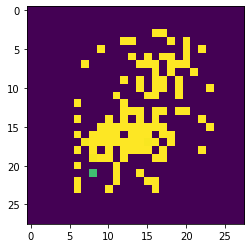

Generator Loss after 25 epoch is 2126.809415102005 and Discriminator loss is 316.2605057656765 on real images and 304.6887445449829 on fake images


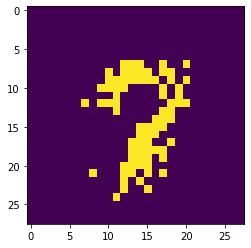

Generator Loss after 26 epoch is 2212.508390903473 and Discriminator loss is 296.87327313423157 on real images and 293.29962357878685 on fake images


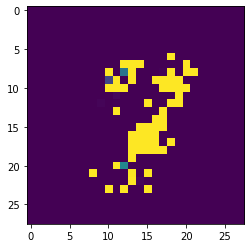

Generator Loss after 27 epoch is 2220.658335208893 and Discriminator loss is 292.50454553961754 on real images and 291.9996688961983 on fake images


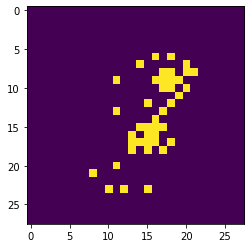

Generator Loss after 28 epoch is 2202.4989355802536 and Discriminator loss is 297.02658838033676 on real images and 294.31926530599594 on fake images


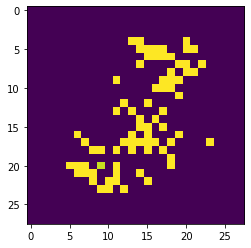

Generator Loss after 29 epoch is 2192.6873787641525 and Discriminator loss is 301.45064076781273 on real images and 295.2056836783886 on fake images


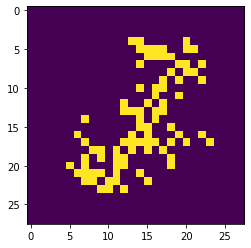

Generator Loss after 30 epoch is 2211.8056371212006 and Discriminator loss is 292.31130078434944 on real images and 293.403112411499 on fake images


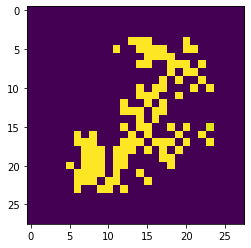

Generator Loss after 31 epoch is 2216.157936811447 and Discriminator loss is 292.195841640234 on real images and 292.50000163912773 on fake images


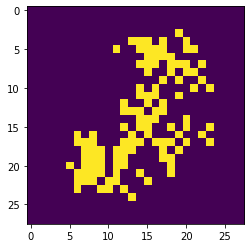

Generator Loss after 32 epoch is 2219.677327632904 and Discriminator loss is 292.24985218048096 on real images and 291.99399104714394 on fake images


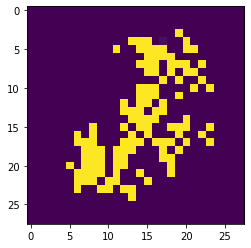

Generator Loss after 33 epoch is 2217.418265581131 and Discriminator loss is 292.17979523539543 on real images and 292.1591096818447 on fake images


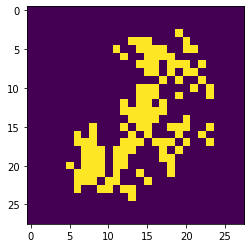

Generator Loss after 34 epoch is 2219.266238451004 and Discriminator loss is 292.13800194859505 on real images and 292.0031962096691 on fake images


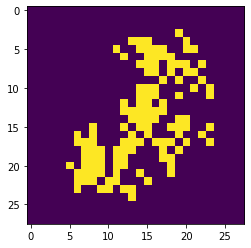

KeyboardInterrupt: 

In [84]:
gen_lr = 0.02
dis_lr = 0.04
noise_ratio = 0.1
generator, discriminator = (None, None)
gc.collect()
generator, discriminator = train(100, smooth=True, add_noise= True, show_test_image= True)

In [12]:
def test_model(discriminator, generator, no_images = 30):
    with torch.no_grad():
        generator.eval()
        latent_result = (torch.rand(no_images,100) - 0.5)/0.5
        if train_on_gpu == True:
            latent_result = latent_result.cuda()

        res_images = generator(latent_result)
        
        k = int(no_images/5)
        
        fig, axes = plt.subplots(5,k, figsize = (30,30))

        for i in range(5):
            for j in range(k):
                img_show = res_images[i*k + j]
                img_show = ((img_show.view(28,28)+1)/2).detach().cpu().data.numpy()
                axes[i][j].imshow(img_show)

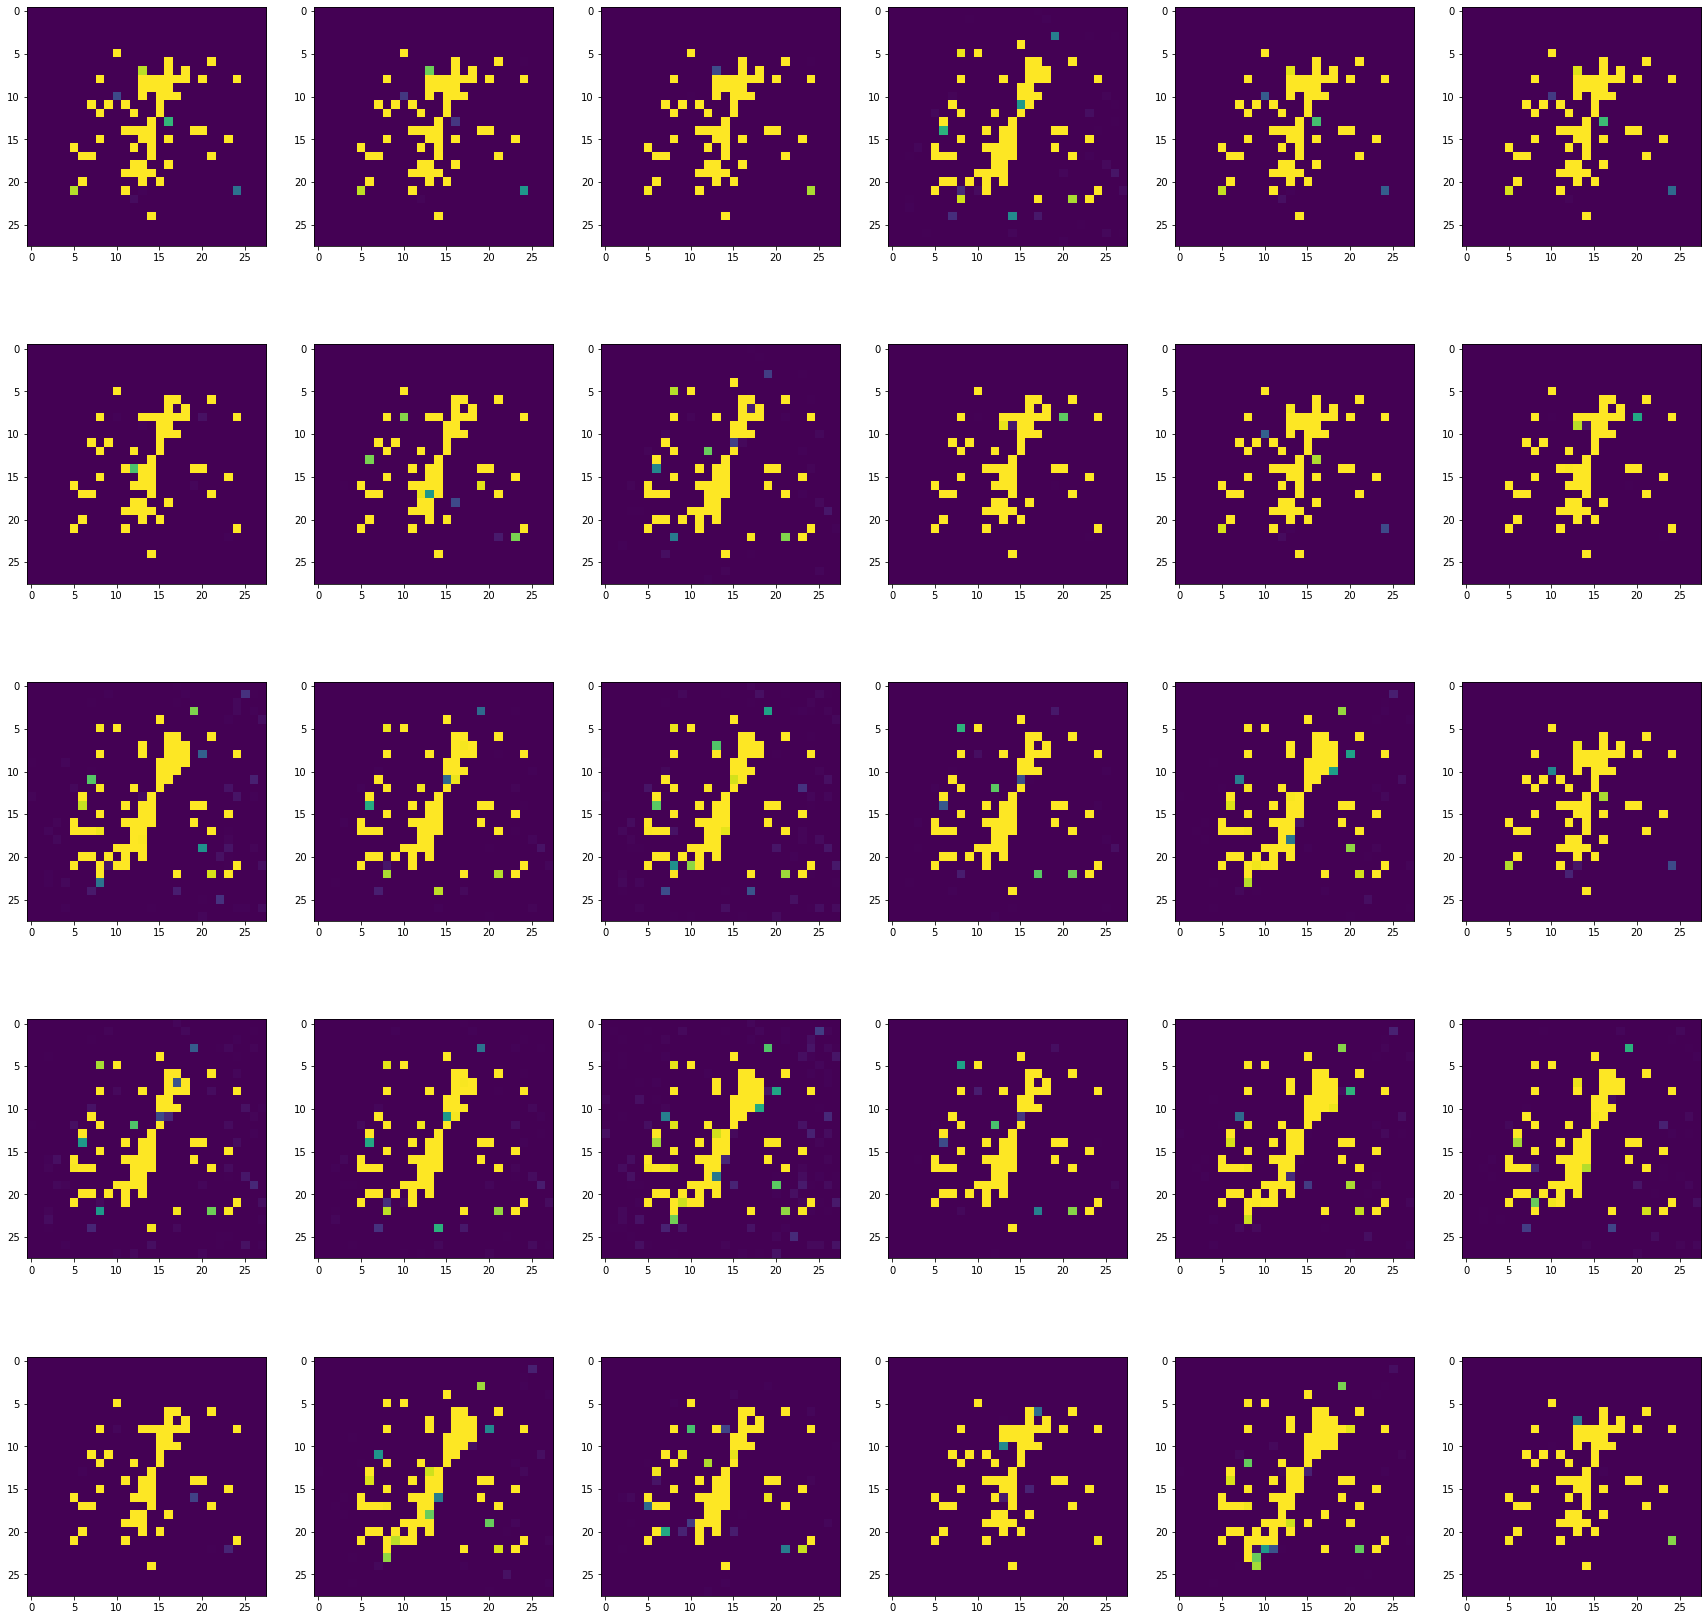

In [19]:
test_model(discriminator, generator)

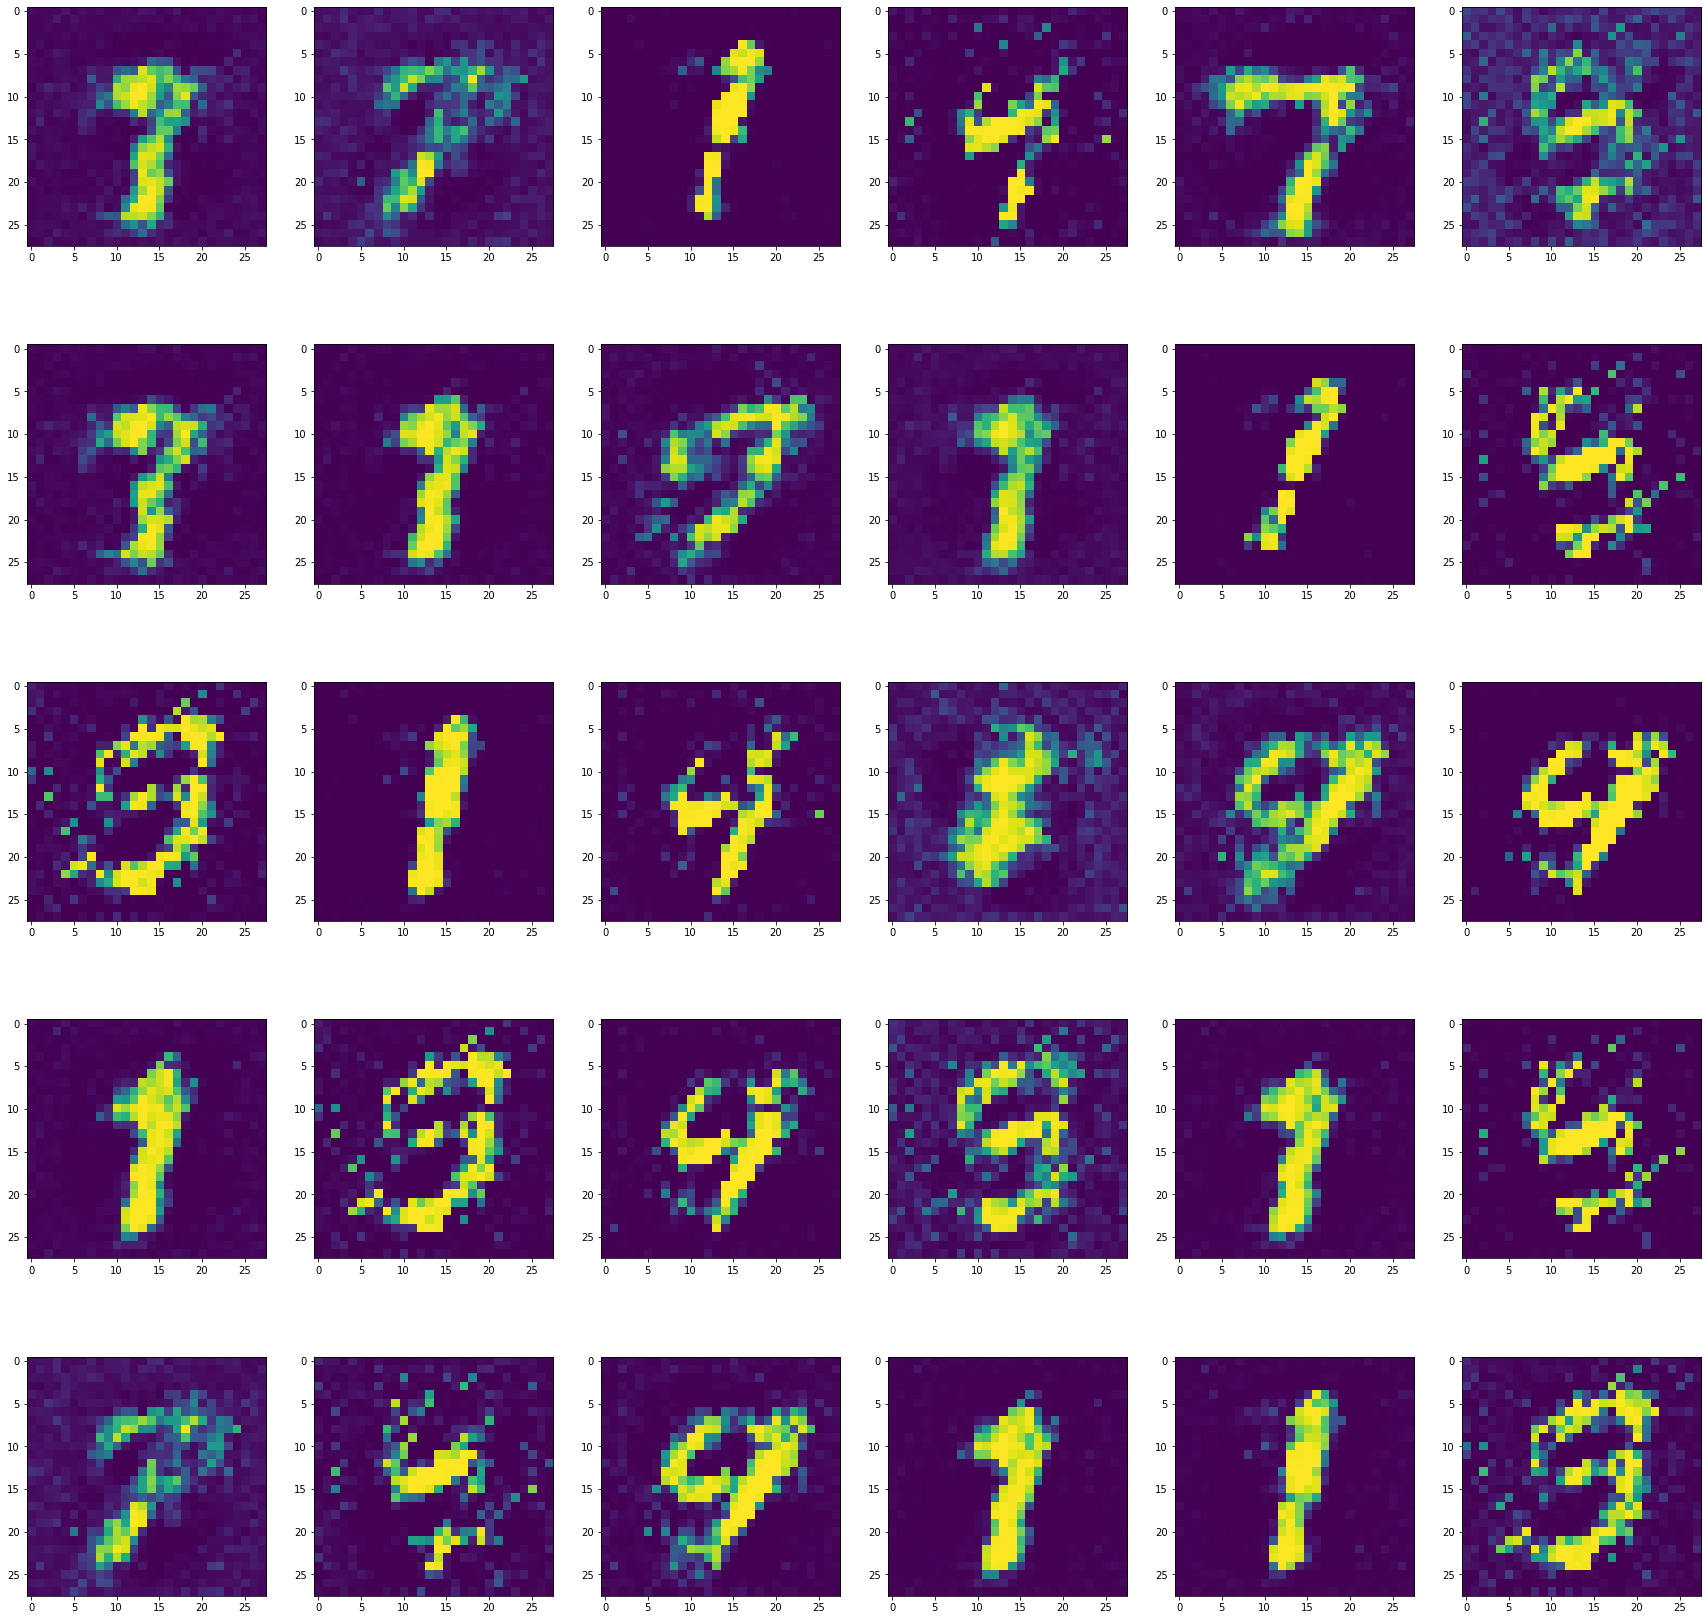

In [21]:
test_model(discriminator, generator)

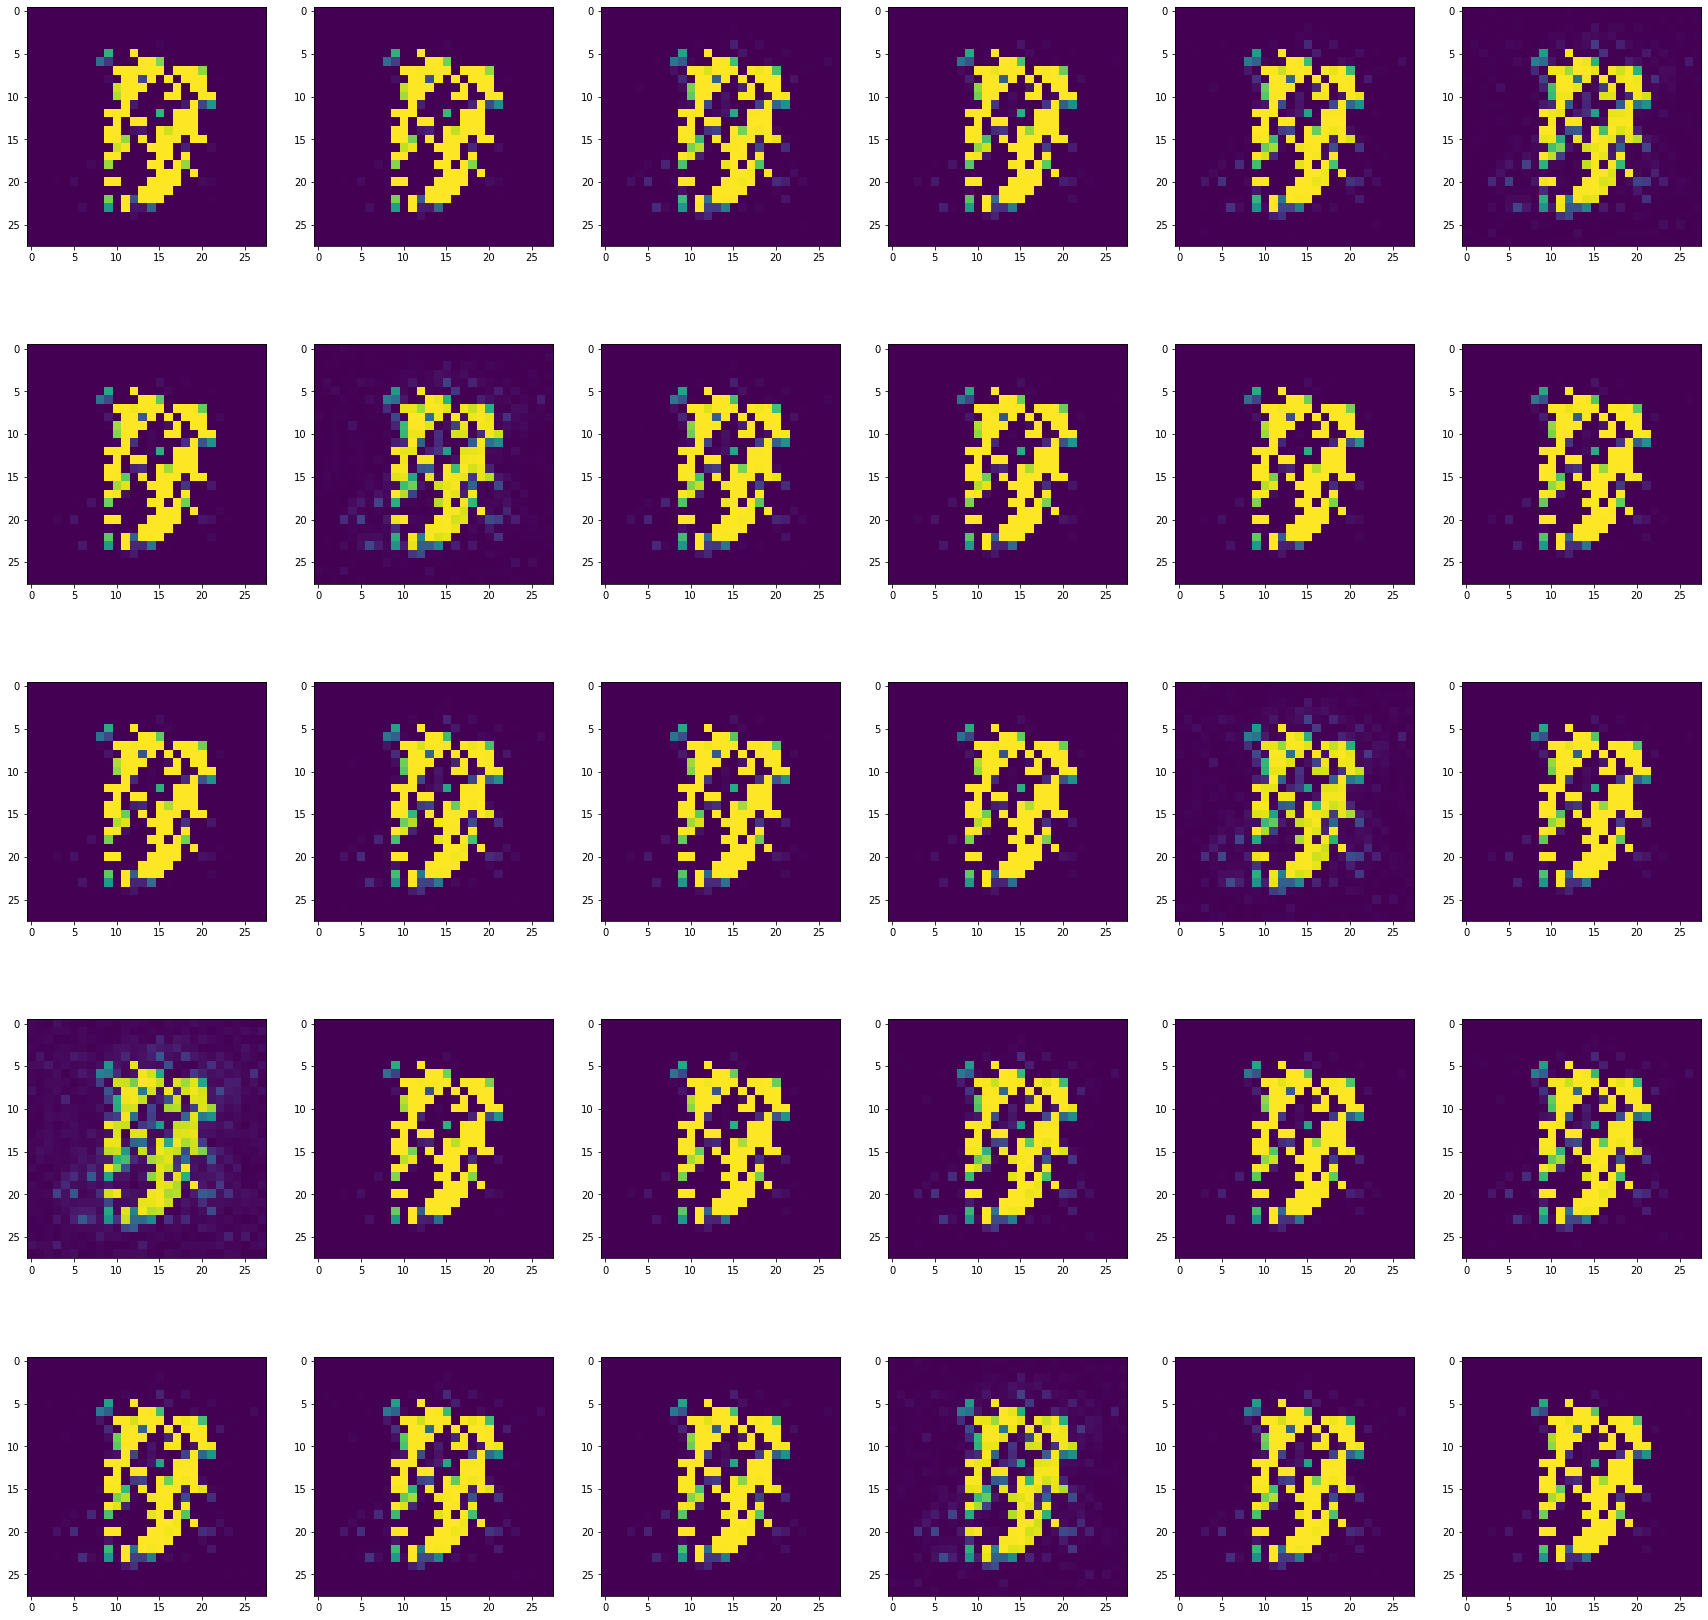

In [75]:
test_model(discriminator, generator)